# Modelo Predictivo de Exportaciones Agrícolas en Colombia hasta 2026

Inicialmente vamos a implementar un proceso ETL (Extract, Transform, Load) para limpiar, transformar y estructurar la información del Dataframe de exportaciones agricolas de Colombia.

### Sobre el Dataset:
Este conjunto de datos presenta la información de las exportaciones del sector agrícola medidas en dólares FOB y toneladas. Las exportaciones presentadas abarcan el ámbito de OMC y pesca.

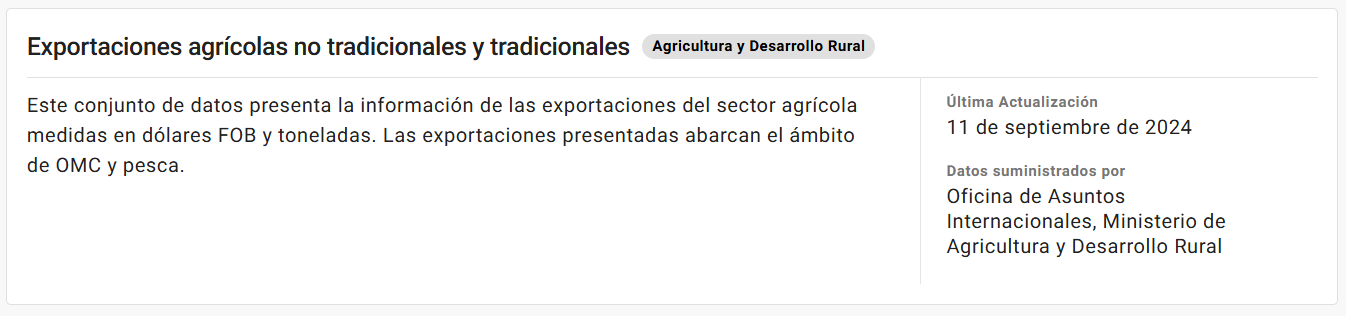

La Columnas que se contienen en el DataFrame son las siguientes:

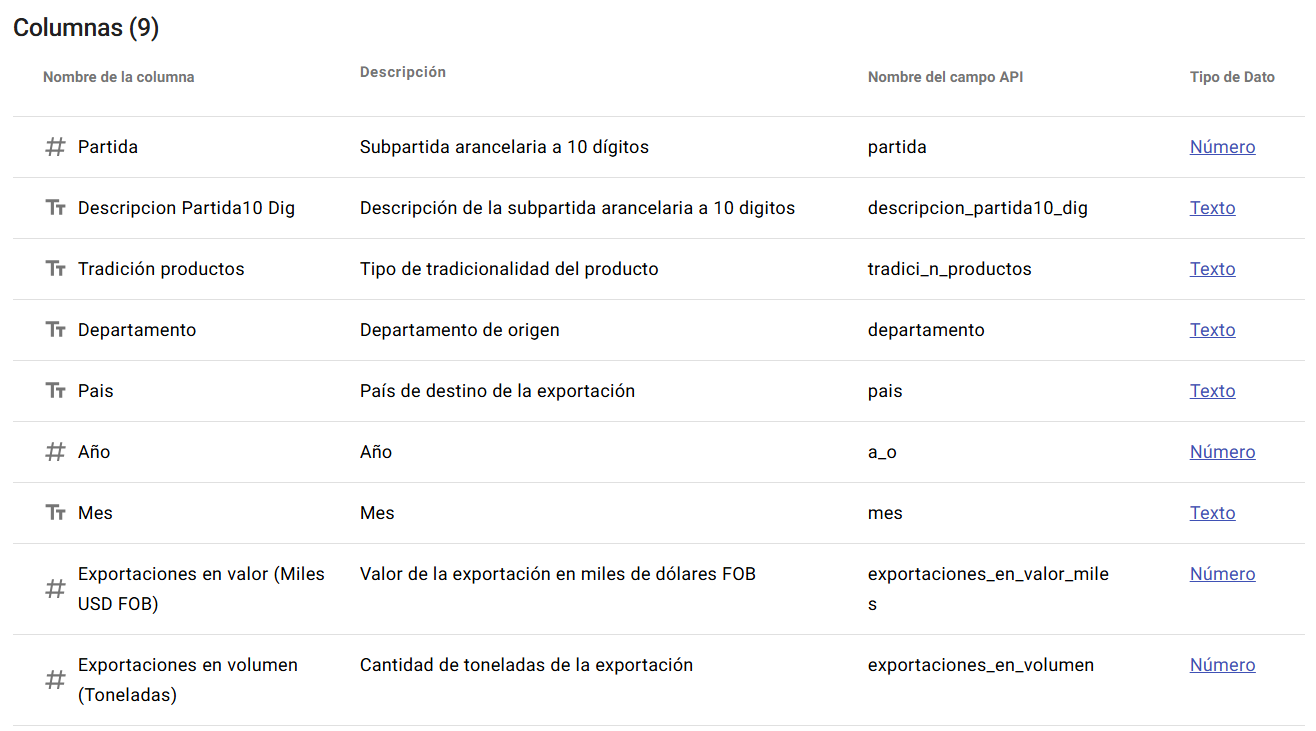

In [1]:
# Importamos todas las librerias aquí:
import pandas as pd
from forex_python.converter import CurrencyRates
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 1. Extracción de Datos (Extract)

In [4]:
# Llamamos nuestro archivo csv
url = "Exportaciones_agricolas.csv"  # Verifica si permite acceso directo
df = pd.read_csv(url)
df.head()

,Partida,Descripcion Partida10 Dig,Tradición productos,Departamento,Pais,Año,Mes,Exportaciones en valor (Miles USD FOB),Exportaciones en volumen (Toneladas)
0,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2019,Abril,0,0
1,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2020,Febrero,0,0
2,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,Enero,0,0
3,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,Abril,0,0
4,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2023,Junio,0,0


**Partida:** En términos de comercio internacional, cada producto tiene un código arancelario que lo clasifica dentro de un sistema de nomenclatura. En este caso, los productos exportados tienen una subpartida de 10 dígitos que identifica de manera específica qué tipo de producto es.

**Descripción Partida:** Es el nombre del producto como tal, esta columna complementa la anterior al proporcionar el nombre del producto asociado a cada código de subpartida.

**Tadicional productos:** Se entiendo como la tradicionalidad del producto, es decir, si es de forma tradicional o no tradicional. En términos de comercio, los productos tradicionales son aquellos que históricamente han sido los principales productos de exportación del país, mientras que los no tradicionales son aquellos que han ganado relevancia más recientemente o tienen menor volumen de exportación.

**Departamento:** El departamendo de donde sale la expostación y el **País** es a donde llega el producto.

**Año y mes:** El año y el mes de exportación, pero están divididas en dos columnas diferentes (las podemos unificar).

**Exportaciones en valor:** Es el valor de la exportación, sin embargo está en miles de dolares FOB (las podemos cambiar).

> **¿Qué significa cada parte?**
> 
> Miles USD:Los valores están expresados en miles de dólares estadounidenses.
> Si ves un valor como 500, significa 500,000 dólares (500 × 1,000).
>
> FOB (Free on Board): Es un término de comercio internacional que indica que el vendedor cubre todos los costos (transporte, aduanas, seguros, etc.) hasta que la mercancía está cargada en el barco (o medio de transporte acordado).
> A partir de ahí, los costos y riesgos corren por cuenta del comprador.

**Exportaciones en volumen:** Es el peso de la expostación, pero está en toneladas (podemos cambiarlas a kg)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475785 entries, 0 to 475784
Data columns (total 9 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   Partida                                 475785 non-null  int64 
 1   Descripcion Partida10 Dig               475785 non-null  object
 2   Tradición productos                     475785 non-null  object
 3   Departamento                            475785 non-null  object
 4   Pais                                    475785 non-null  object
 5   Año                                     475785 non-null  int64 
 6   Mes                                     475785 non-null  object
 7   Exportaciones en valor (Miles USD FOB)  475785 non-null  int64 
 8   Exportaciones en volumen (Toneladas)    475785 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 32.7+ MB


Lo primero que podemos notar es que nuestro DataFrame no tiene dato nulos, es decir, todas las filas están llenas.

In [10]:
df.isnull().sum()  # Ver cuántos valores nulos hay por columna
#df.fillna(method='ffill', inplace=True)  # Rellenar valores faltantes

Partida                                   0
Descripcion Partida10 Dig                 0
Tradición productos                       0
Departamento                              0
Pais                                      0
Año                                       0
Mes                                       0
Exportaciones en valor (Miles USD FOB)    0
Exportaciones en volumen (Toneladas)      0
dtype: int64

In [12]:
df.describe()

,Partida,Año,Exportaciones en valor (Miles USD FOB),Exportaciones en volumen (Toneladas)
count,4.757850e+05,475785.000000,475785.000000,475785.000000
mean,1.355740e+09,2021.371777,110.950982,64.708049
std,7.618771e+08,1.609222,943.437868,714.815422
min,1.012100e+08,2019.000000,0.000000,0.000000
25%,7.129010e+08,2020.000000,0.000000,0.000000
50%,1.211903e+09,2021.000000,1.000000,0.000000
75%,2.005700e+09,2023.000000,17.000000,4.000000
max,5.302900e+09,2024.000000,92600.000000,60979.000000


### 2. Transformación de Datos (Transform)

In [15]:
# Diccionario para convertir los meses en español a números
meses_dict = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, "Junio": 6,
    "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Reemplazar los nombres de los meses con sus valores numéricos
df["Mes"] = df["Mes"].map(meses_dict)

# Convertir "Año" y "Mes" en una sola columna de fecha
df["Fecha"] = pd.to_datetime(df["Año"].astype(str) + "-" + df["Mes"].astype(str), format="%Y-%m")

In [16]:
df

,Partida,Descripcion Partida10 Dig,Tradición productos,Departamento,Pais,Año,Mes,Exportaciones en valor (Miles USD FOB),Exportaciones en volumen (Toneladas),Fecha
0,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2019,4,0,0,2019-04-01
1,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2020,2,0,0,2020-02-01
2,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,1,0,0,2022-01-01
3,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,4,0,0,2022-04-01
4,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2023,6,0,0,2023-06-01
...,...,...,...,...,...,...,...,...,...,...
475780,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Antioquia,Suiza,2023,12,0,0,2023-12-01
475781,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Bogotá,Ecuador,2020,2,0,0,2020-02-01
475782,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Bogotá,República Dominicana,2020,10,0,0,2020-10-01
475783,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Caldas,China,2022,1,0,0,2022-01-01


Para el cambio de la moneda, vamos a utilizar una API para hacerlo en tiempo real: https://app.exchangerate-api.com/keys/added

In [18]:
url = "https://v6.exchangerate-api.com/v6/e6988468efe3565fdf0d50c3/latest/USD"

response = requests.get(url)

# Imprimir la respuesta cruda para ver si hay errores
print(f"Status Code: {response.status_code}")
print(f"Raw Response: {response.text}")

# Intentar convertir a JSON solo si la respuesta es válida
if response.status_code == 200 and response.text:
    data = response.json()
    if "conversion_rates" in data:
        tasa_cambio = data["conversion_rates"]["COP"]
        print(f"Tasa de cambio actual (USD a COP): {tasa_cambio}")
    else:
        print("Error: No se encontraron datos de tasas de cambio en la respuesta.")
else:
    print("Error al obtener la tasa de cambio. Verifica tu API Key y la URL.")


Status Code: 200
Raw Response: {
 "result":"success",
 "documentation":"https://www.exchangerate-api.com/docs",
 "terms_of_use":"https://www.exchangerate-api.com/terms",
 "time_last_update_unix":1743465601,
 "time_last_update_utc":"Tue, 01 Apr 2025 00:00:01 +0000",
 "time_next_update_unix":1743552001,
 "time_next_update_utc":"Wed, 02 Apr 2025 00:00:01 +0000",
 "base_code":"USD",
 "conversion_rates":{
  "USD":1,
  "AED":3.6725,
  "AFN":70.5812,
  "ALL":91.6527,
  "AMD":391.7039,
  "ANG":1.7900,
  "AOA":918.5688,
  "ARS":1073.8800,
  "AUD":1.6020,
  "AWG":1.7900,
  "AZN":1.7004,
  "BAM":1.8084,
  "BBD":2.0000,
  "BDT":121.4200,
  "BGN":1.8084,
  "BHD":0.3760,
  "BIF":2965.8506,
  "BMD":1.0000,
  "BND":1.3432,
  "BOB":6.8828,
  "BRL":5.7515,
  "BSD":1.0000,
  "BTN":85.4987,
  "BWP":13.7352,
  "BYN":3.2657,
  "BZD":2.0000,
  "CAD":1.4377,
  "CDF":2859.4349,
  "CHF":0.8832,
  "CLP":947.8727,
  "CNY":7.2610,
  "COP":4153.1783,
  "CRC":496.7638,
  "CUP":24.0000,
  "CVE":101.9509,
  "CZK":23.0

In [21]:
#Esta sería la tasa de cambio actual para pasar de dolares a pesos colombianos
tasa_cambio

4153.1783

In [22]:

# Calcular el valor en dólares
df['Exportaciones en USD'] = df['Exportaciones en valor (Miles USD FOB)'] * 1000

# Convertir a pesos colombianos
df['Exportaciones en COP'] = df['Exportaciones en USD'] * tasa_cambio

# Se divide entre 1_000_000, para trabajar en millones de pesos COP
df['Exportaciones en COP'] = df['Exportaciones en COP']/1_000_000_000_000
# Verificar las primeras filas para confirmar la conversión
df

,Partida,Descripcion Partida10 Dig,Tradición productos,Departamento,Pais,Año,Mes,Exportaciones en valor (Miles USD FOB),Exportaciones en volumen (Toneladas),Fecha,Exportaciones en USD,Exportaciones en COP
0,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2019,4,0,0,2019-04-01,0,0.0
1,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2020,2,0,0,2020-02-01,0,0.0
2,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,1,0,0,2022-01-01,0,0.0
3,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2022,4,0,0,2022-04-01,0,0.0
4,101210000,"Caballos reproductores de raza pura, vivos",No tradicional,Antioquia,China,2023,6,0,0,2023-06-01,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
475780,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Antioquia,Suiza,2023,12,0,0,2023-12-01,0,0.0
475781,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Bogotá,Ecuador,2020,2,0,0,2020-02-01,0,0.0
475782,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Bogotá,República Dominicana,2020,10,0,0,2020-10-01,0,0.0
475783,5302900000,Estopas y desperdicios de cáñamo (incluidos lo...,No tradicional,Caldas,China,2022,1,0,0,2022-01-01,0,0.0


### 3. Carga y Almacenamiento de Datos (Load)

In [27]:
df.to_csv("Exportaciones_limpias.csv", index=False)

### 4. Análisis Descriptivo Inicial

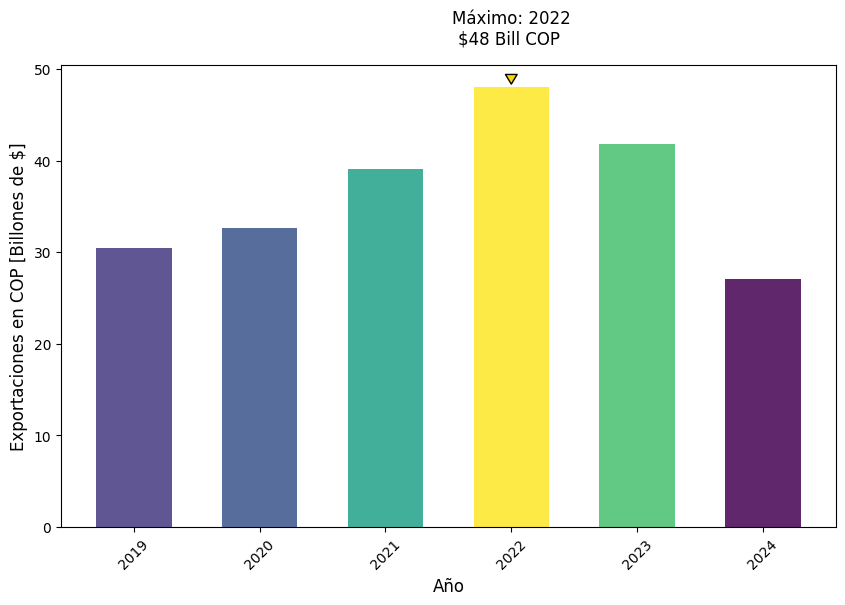

In [29]:

# Agrupar las exportaciones en COP por año
Exportaciones_año = df.groupby(df['Fecha'].dt.year)['Exportaciones en COP'].sum()

# Normalizar los valores para mapear los colores (más alto = más intenso)
norm = (Exportaciones_año - Exportaciones_año.min()) / (Exportaciones_año.max() - Exportaciones_año.min())

# Usar la paleta "magma" para asignar colores con base en los valores normalizados
colors = plt.cm.viridis(norm)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear las barras con los colores ajustados
bars = ax.bar(Exportaciones_año.index, Exportaciones_año.values, color=colors, alpha=0.85, width=0.6)

# Agregar título y etiquetas
# ax.set_title("Exportaciones en COP por Año", fontsize=14, fontweight="bold")
ax.set_xlabel("Año", fontsize=12)
ax.set_ylabel("Exportaciones en COP [Billones de $]", fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Identificar el año con mayor exportación
max_anio = Exportaciones_año.idxmax()
max_valor = Exportaciones_año.max()

# Agregar anotación del año con mayor exportación
ax.annotate(f'Máximo: {max_anio}\n${max_valor:,.0f} Bill COP \n',
            xy=(max_anio, max_valor), 
            xytext=(max_anio, max_valor * 1.05),
            ha='center', fontsize=12, color='black',
            arrowprops=dict(facecolor='gold', arrowstyle='wedge,tail_width=0.7'))

# Mostrar el gráfico
plt.show()


* Se observa una tendencia al alza en las exportaciones desde 2019 hasta 2022, alcanzando un pico en ese último año con aproximadamente 48 billones de COP.

* Sin embargo, en 2023 se evidencia una leve disminución y en 2024 hay una caída más pronunciada.

* Esto podría estar relacionado con factores económicos globales o nacionales, cambios en la demanda de productos exportados o variaciones en el tipo de cambio.

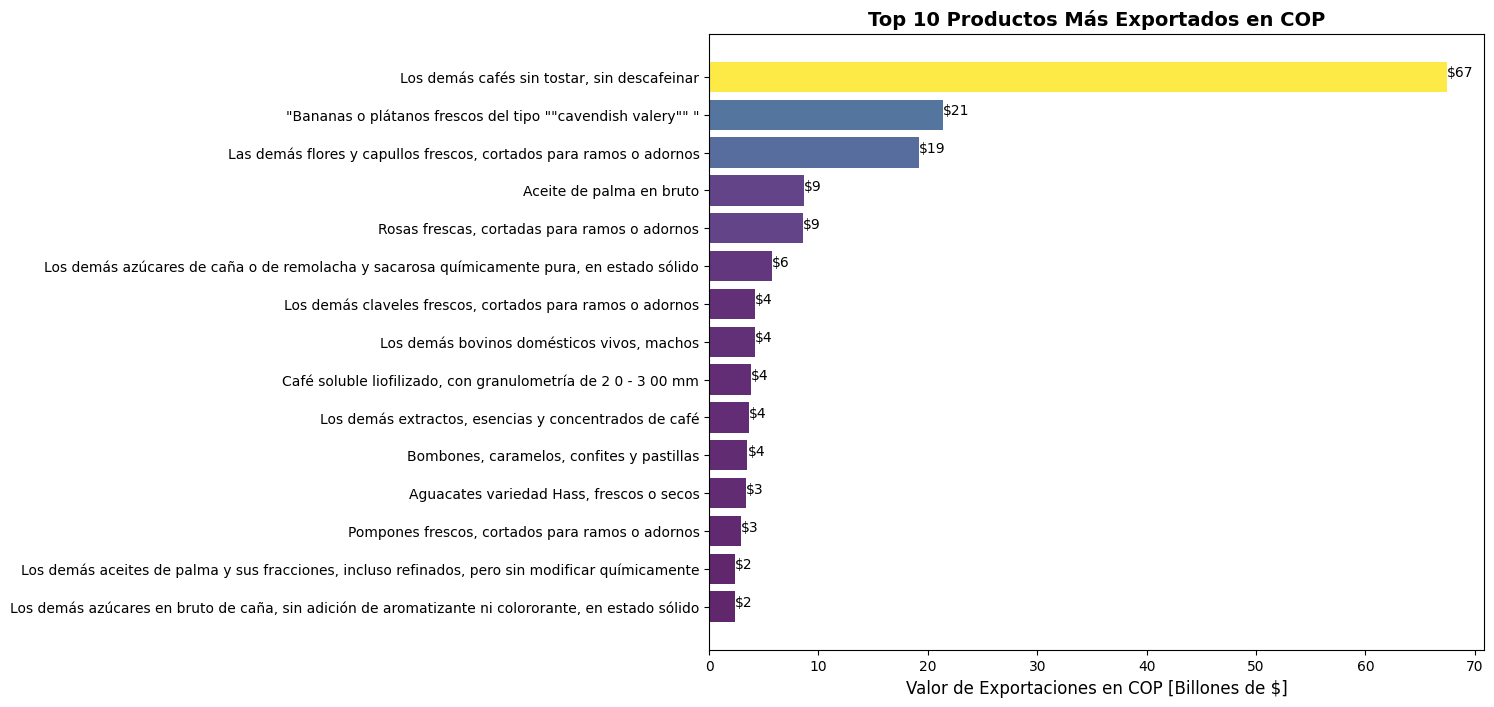

In [31]:
# Obtener el top 10 o 15 productos más exportados
top_productos = df.groupby('Descripcion Partida10 Dig')['Exportaciones en COP'].sum().sort_values(ascending=False).head(15)

# Normalizar valores para aplicar el degradado en la paleta magma
norm = (top_productos - top_productos.min()) / (top_productos.max() - top_productos.min())
colors = plt.cm.viridis(norm)

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 8))

# Crear las barras horizontales
bars = ax.barh(top_productos.index, top_productos.values, color=colors, alpha=0.85)

# Invertir el orden del eje Y para que el producto más vendido esté arriba
ax.invert_yaxis()

# Agregar etiquetas y título
ax.set_title("Top 10 Productos Más Exportados en COP", fontsize=14, fontweight="bold")
ax.set_xlabel("Valor de Exportaciones en COP [Billones de $]", fontsize=12)

# Agregar etiquetas de valores en las barras
for bar, valor in zip(bars, top_productos.values):
    ax.text(valor, bar.get_y() + bar.get_height()/2, f"${valor:,.0f}", va='baseline', fontsize=10, color='black')

# Mostrar el gráfico
plt.show()

* El café sin tostar es, con diferencia, el producto más exportado, generando 67 billones de COP, muy por encima del segundo producto más exportado: bananas tipo Cavendish Valery con 21 billones de COP.

* También destacan las exportaciones de flores y productos agrícolas como aceite de palma y azúcar.

* Esto reafirma la importancia del sector agroindustrial en la economía exportadora del país.

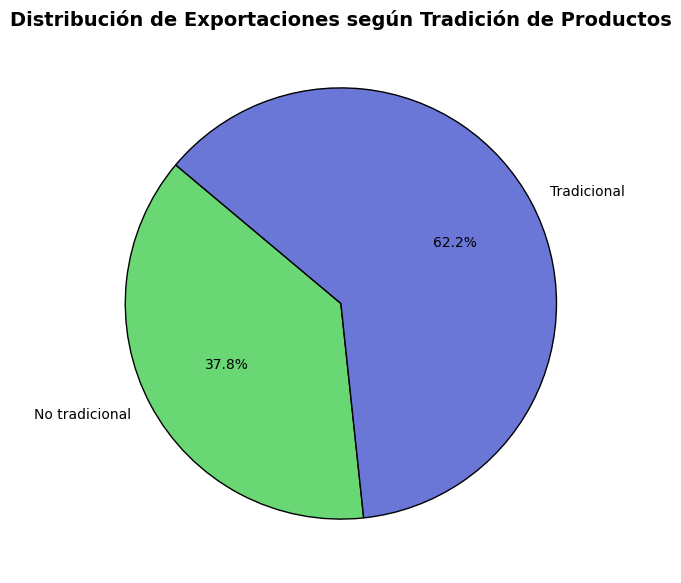

In [33]:
# Contar la cantidad total de exportaciones por tipo de tradición
tradicion_counts = df.groupby("Tradición productos")["Exportaciones en COP"].sum()

# Definir colores personalizados
colors = ["#6ad775", "#6a77d7"]  # Rojo y morado oscuro (ajustable)

# Crear el gráfico de pastel
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(tradicion_counts, labels=tradicion_counts.index, autopct='%1.1f%%', 
       colors=colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Agregar título
ax.set_title("Distribución de Exportaciones según Tradición de Productos", fontsize=14, fontweight="bold")

# Mostrar el gráfico
plt.show()

* Los productos tradicionales representan el 62.2% de las exportaciones, mientras que los no tradicionales abarcan el 37.8%.

* Esto sugiere que, aunque hay diversificación en los productos exportados, los sectores históricos como el café, banano y flores siguen dominando.

* Un posible análisis futuro podría ser evaluar cómo han evolucionado estos porcentajes a lo largo del tiempo y si hay una tendencia hacia una mayor diversificación.

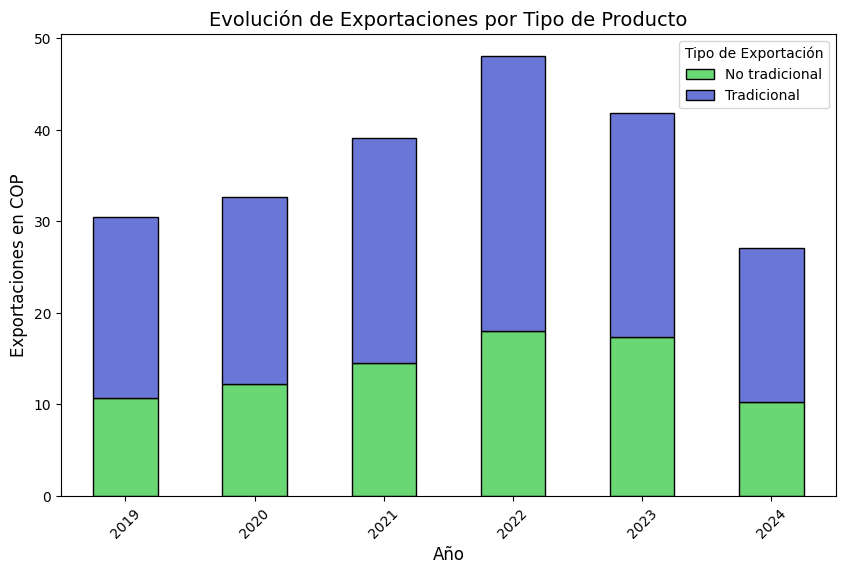

In [35]:
# Convertir 'Fecha' a tipo datetime para extraer el año
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Año'] = df['Fecha'].dt.year

# Agrupar por año y tipo de exportación
df_grouped = df.groupby(['Año', 'Tradición productos'])['Exportaciones en COP'].sum().unstack()

# Graficar barras apiladas
df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, edgecolor='black')

# Personalizar el gráfico
plt.title("Evolución de Exportaciones por Tipo de Producto", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Exportaciones en COP", fontsize=12)
plt.legend(title="Tipo de Exportación")
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

In [36]:
df['Tradición productos'].unique()

array(['No tradicional', 'Tradicional'], dtype=object)

In [38]:
df['Departamento'].unique()

array(['Antioquia', 'Bogotá', 'Cundinamarca', 'No diligenciado',
       'Valle del Cauca', 'Norte de Santander', 'Atlántico', 'Bolívar',
       'Santander', 'Risaralda', 'Tolima', 'Cauca', 'Caldas', 'Boyacá',
       'Córdoba', 'Sucre', 'Meta', 'Cesar', 'Casanare', 'Huila', 'Chocó',
       'La Guajira', 'Nariño', 'Amazonas', 'Magdalena', 'Quindío',
       'San Andrés y Providencia', 'Arauca', 'Guainía', 'Putumayo',
       'Vaupés', 'Caquetá', 'Guaviare', 'Vichada'], dtype=object)

<Figure size 1200x600 with 0 Axes>

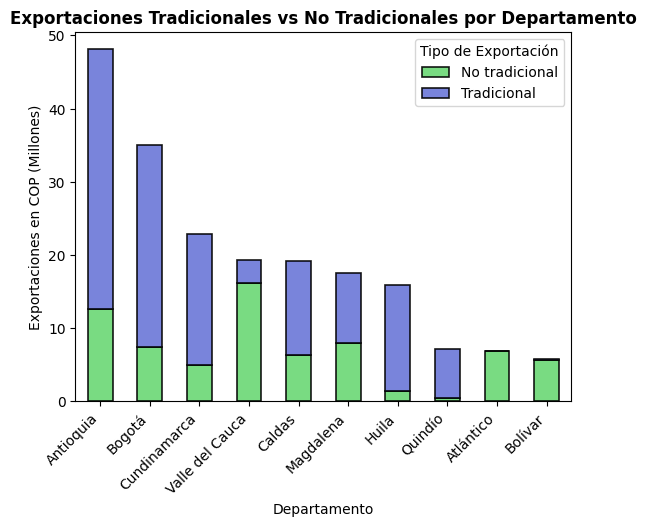

In [45]:
# Agrupar por departamento y tipo de tradición y sumar las exportaciones
df_grouped = df.groupby(["Departamento", "Tradición productos"])["Exportaciones en COP"].sum().unstack()

# Tomar solo los 10 departamentos con mayor exportación total
top_departamentos = df_grouped.sum(axis=1).nlargest(10).index
df_top = df_grouped.loc[top_departamentos]

# Crear gráfico de barras apilado
plt.figure(figsize=(12, 6))
df_top.plot(kind="bar", stacked=True, color=colors, edgecolor="black", linewidth=1.2, alpha=0.9)

# Agregar etiquetas y título
plt.xticks(rotation=45, ha="right")  # Rotar etiquetas para mejor visibilidad
plt.ylabel("Exportaciones en COP (Millones)")
plt.xlabel("Departamento")
plt.title("Exportaciones Tradicionales vs No Tradicionales por Departamento", fontsize=12, fontweight="bold")
plt.legend(title="Tipo de Exportación")

# Mostrar gráfico
plt.show()

In [47]:
df['Pais'].unique()

array(['China', 'Colombia', 'Estados Unidos', 'Panamá', 'Puerto Rico',
       'República Dominicana', 'Argentina', 'Aruba', 'Bélgica', 'Chile',
       'Costa Rica', 'Curazao', 'Ecuador', 'España', 'Guatemala',
       'México', 'Países Bajos', 'Perú', 'Reino Unido', 'Bolivia',
       'Qatar', 'Canadá', 'Venezuela', 'Egipto', 'Irak', 'Arabia Saudita',
       'Jordania', 'Líbano', 'Dinamarca', 'Uruguay', 'Brasil', 'Francia',
       'Alemania', 'Emiratos Árabes Unidos', 'Singapur', 'Italia',
       'Grecia', 'Polonia', 'Nicaragua', 'El Salvador', 'Corea', 'Guinea',
       'India', 'Israel', 'Japón', 'Portugal', 'República Checa',
       'Suecia', 'Turquía', 'Azerbaiyán', 'Honduras', 'Hungría',
       'Paraguay', 'Rusia, Federación de', 'Ucrania', 'Serbia',
       'Australia', 'Austria', 'Bahamas', 'Bahrein', 'Bangla Desh',
       'Bulgaria', 'Chipre', 'Eslovaquia', 'Estonia', 'Filipinas',
       'Finlandia', 'Hong Kong', 'Indonesia', 'Irlanda', 'Kazajstán',
       'Kenia', 'Kuwait', 'Litua

<Figure size 1200x600 with 0 Axes>

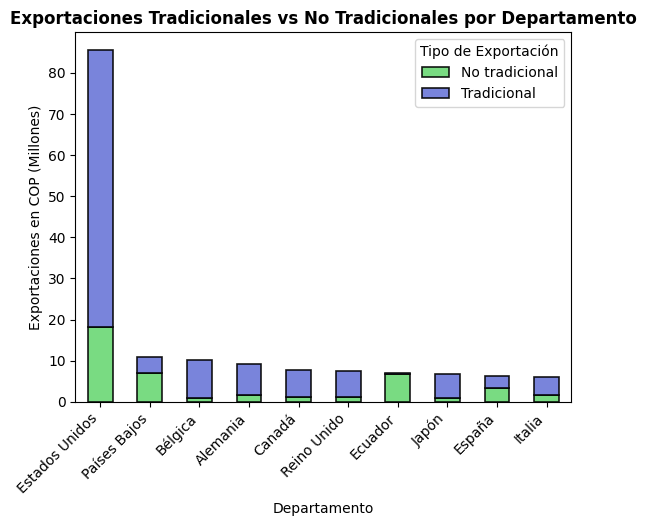

In [49]:
# Agrupar por departamento y tipo de tradición y sumar las exportaciones
df_grouped = df.groupby(["Pais", "Tradición productos"])["Exportaciones en COP"].sum().unstack()

# Tomar solo los 10 departamentos con mayor exportación total
top_pais = df_grouped.sum(axis=1).nlargest(10).index
df_top = df_grouped.loc[top_pais]

# Crear gráfico de barras apilado
plt.figure(figsize=(12, 6))
df_top.plot(kind="bar", stacked=True, color=colors, edgecolor="black", linewidth=1.2, alpha=0.9)

# Agregar etiquetas y título
plt.xticks(rotation=45, ha="right")  # Rotar etiquetas para mejor visibilidad
plt.ylabel("Exportaciones en COP (Millones)")
plt.xlabel("Departamento")
plt.title("Exportaciones Tradicionales vs No Tradicionales por Departamento", fontsize=12, fontweight="bold")
plt.legend(title="Tipo de Exportación")

# Mostrar gráfico
plt.show()

## 🔍 Fase 1: Análisis exploratorio y correlación
Antes de seleccionar un modelo, debemos explorar la relación entre las variables para identificar cuáles son más influyentes. Esto incluye:

✔️ Matriz de correlación: Para ver la relación entre Exportaciones en COP, Año, Tipo de exportación y otras variables.

✔️ Gráficos de dispersión y distribuciones: Para detectar tendencias o patrones.

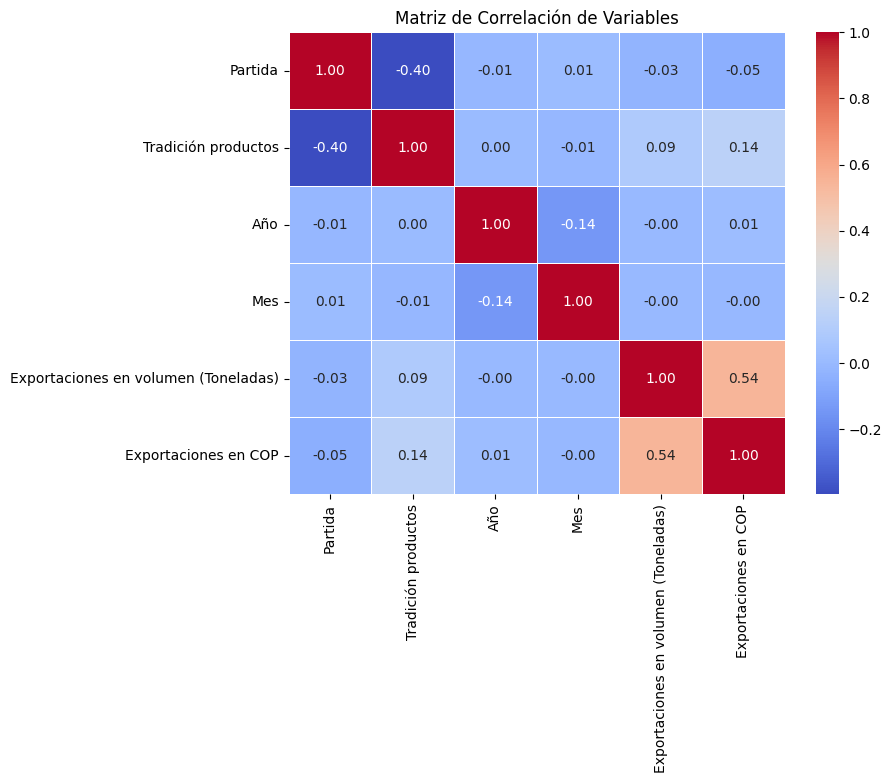

In [52]:
# Convertir las columnas no numéricas a numéricas, si no lo has hecho
df['Tradición productos'] = df['Tradición productos'].astype('category').cat.codes

# Seleccionar solo las columnas numéricas y excluir la columna 'Exportaciones en USD'
df_numeric = df.select_dtypes(include=['number']).drop(columns=['Exportaciones en USD', 'Exportaciones en valor (Miles USD FOB)'])

# Matriz de correlación para las columnas numéricas (excluyendo 'Exportaciones en USD')
plt.figure(figsize=(8, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación de Variables")
plt.show()


Pasos para construir y evaluar la red neuronal
1. Preparación de los datos
Para crear un modelo de red neuronal, debemos asegurarnos de que los datos estén listos. Aquí vamos a realizar algunos pasos importantes:

Codificar las variables categóricas como la columna de "tradición productos".

Normalizar los datos numéricos como las columnas "exportaciones en volumen" y "exportaciones en COP".

Convertir la columna de año y mes en características relevantes.

Separar los datos en conjuntos de entrenamiento y prueba.

2. Definir la red neuronal (MLP)
Utilizaremos una red neuronal simple con capas densas. El modelo tendrá una capa de entrada, capas ocultas y una capa de salida que predice el valor de exportación (en volumen o COP, según lo que estemos buscando predecir).

3. Entrenar y evaluar el modelo
Utilizaremos funciones de pérdida y optimización adecuadas para entrenar el modelo y luego evaluaremos su desempeño.

C:\Users\Alexander\AppData\Local\Temp\ipykernel_13556\875851652.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']] = scaler.fit_transform(X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']])
C:\Users\Alexander\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - loss: 0.0019 - val_loss: 7.5981e-05
Epoch 2/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 2.6851e-05 - val_loss: 5.7160e-06
Epoch 3/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - loss: 9.3101e-06 - val_loss: 5.9649e-06
Epoch 4/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 7.8290e-06 - val_loss: 5.5914e-06
Epoch 5/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - loss: 8.5261e-06 - val_loss: 5.1890e-06
Epoch 6/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - loss: 1.0075e-05 - val_loss: 5.4747e-06
Epoch 7/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 1.0592e-05 - val_loss: 5.2290e-06
Epoch 8/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - loss: 8.6843e-06 - val_loss: 5.4666e-06
Epoch 9/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - loss: 8.4747e-06 - val_loss: 5.3904e-06
Epoch 10/100
11895/11895 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - loss: 8.0932e-06 - val_loss: 5.7289e-06
Epo

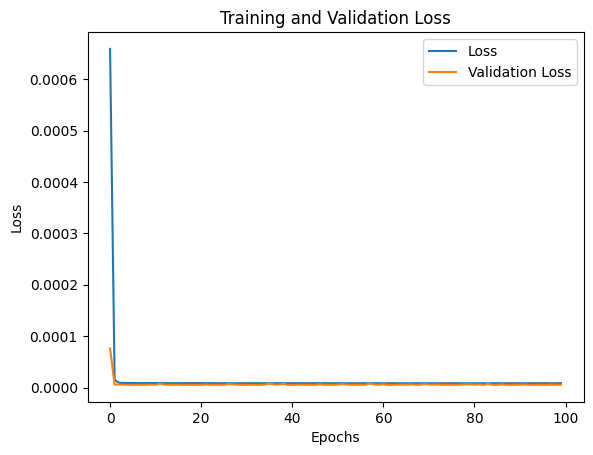

In [65]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv('Exportaciones_limpias.csv')

# Codificar la columna 'Tradición productos' (Si es tradicional o no)
df['Tradición productos'] = df['Tradición productos'].astype('category').cat.codes

# Asegurarnos de que la columna 'Fecha' esté en formato datetime
df["Fecha"] = pd.to_datetime(df["Año"].astype(str) + "-" + df["Mes"].astype(str), format="%Y-%m")

# Extraer el Año y Mes de la columna 'Fecha'
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month

# Seleccionar las características relevantes
X = df[['Tradición productos', 'Año', 'Mes', 'Exportaciones en volumen (Toneladas)']]  # Características de entrada
y = df['Exportaciones en COP']  # Etiqueta (target)

# Normalizar las características numéricas
scaler = StandardScaler()
X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']] = scaler.fit_transform(X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']])

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir el modelo de red neuronal
model = keras.Sequential()

# Capa de entrada (tamaño igual al número de características)
model.add(layers.Dense(64, activation='relu', input_dim=X_train.shape[1]))

# Capa oculta
model.add(layers.Dense(64, activation='relu'))

# Capa de salida
model.add(layers.Dense(1))  # Para regresión, no se usa función de activación

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualizar el desempeño durante el entrenamiento
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
# Crear un DataFrame con los valores reales y predichos
resultados = pd.DataFrame({
    'Exportaciones Reales (COP)': y_test.values,
    'Exportaciones Predichas (COP)': y_pred.flatten()
})

# Guardar en un archivo CSV
resultados.to_csv('Resultados_Prediccion_Exportaciones.csv', index=False)

print("Resultados guardados en 'Resultados_Prediccion_Exportaciones.csv'")


Resultados guardados en 'Resultados_Prediccion_Exportaciones.csv'


In [69]:
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 0.0023709592621263017


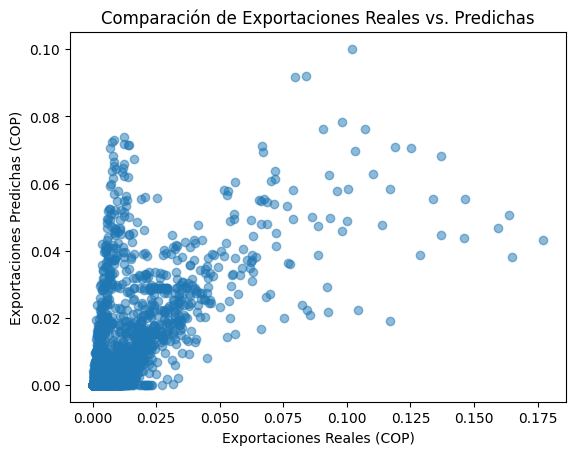

In [71]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Exportaciones Reales (COP)")
plt.ylabel("Exportaciones Predichas (COP)")
plt.title("Comparación de Exportaciones Reales vs. Predichas")
plt.show()


C:\Users\Alexander\AppData\Local\Temp\ipykernel_13556\3560307688.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']] = scaler.fit_transform(X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']])


📌 Regresión Lineal Múltiple:
   - Mean Squared Error (MSE): 0.00000754
   - Root Mean Squared Error (RMSE): 0.002746
----------------------------------------
✅ Resultados guardados en: resultados_regresion_lineal.csv

📌 Random Forest:
   - Mean Squared Error (MSE): 0.00000684
   - Root Mean Squared Error (RMSE): 0.002615
----------------------------------------
✅ Resultados guardados en: resultados_random_forest.csv

📌 XGBoost:
   - Mean Squared Error (MSE): 0.00000573
   - Root Mean Squared Error (RMSE): 0.002393
----------------------------------------
✅ Resultados guardados en: resultados_xgboost.csv



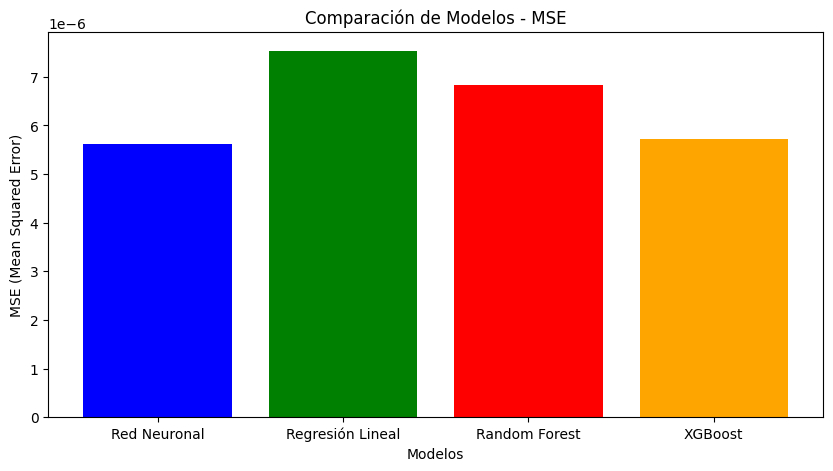

In [79]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv('Exportaciones_limpias.csv')

# Codificar la columna 'Tradición productos'
df['Tradición productos'] = df['Tradición productos'].astype('category').cat.codes

# Asegurar que 'Fecha' esté en formato datetime
df["Fecha"] = pd.to_datetime(df["Año"].astype(str) + "-" + df["Mes"].astype(str), format="%Y-%m")

# Seleccionar las características y la variable objetivo
X = df[['Tradición productos', 'Año', 'Mes', 'Exportaciones en volumen (Toneladas)']]
y = df['Exportaciones en COP']

# Almacenar el nombre del producto para identificarlo en el archivo
productos = df[['Descripcion Partida10 Dig']]

# Normalizar las características numéricas
scaler = StandardScaler()
X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']] = scaler.fit_transform(X[['Año', 'Mes', 'Exportaciones en volumen (Toneladas)']])

# Dividir los datos en conjuntos de entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test, productos_train, productos_test = train_test_split(X, y, productos, test_size=0.2, random_state=42)

# Función para entrenar, evaluar y guardar los resultados
def evaluar_y_guardar(modelo, nombre_modelo, archivo_salida):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"📌 {nombre_modelo}:")
    print(f"   - Mean Squared Error (MSE): {mse:.8f}")
    print(f"   - Root Mean Squared Error (RMSE): {rmse:.6f}")
    print("-" * 40)

    # Guardar los resultados en un archivo CSV
    resultados = pd.DataFrame({
        'Producto': productos_test.values.flatten(),
        'Valor Real': y_test.values,
        'Predicción': y_pred,
        'Error': y_test.values - y_pred
    })
    resultados.to_csv(archivo_salida, index=False)
    print(f"✅ Resultados guardados en: {archivo_salida}\n")
    
    return mse, rmse

# 1️⃣ Regresión Lineal Múltiple
modelo_lr = LinearRegression()
mse_lr, rmse_lr = evaluar_y_guardar(modelo_lr, "Regresión Lineal Múltiple", "resultados_regresion_lineal.csv")

# 2️⃣ Random Forest
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
mse_rf, rmse_rf = evaluar_y_guardar(modelo_rf, "Random Forest", "resultados_random_forest.csv")

# 3️⃣ XGBoost
modelo_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
mse_xgb, rmse_xgb = evaluar_y_guardar(modelo_xgb, "XGBoost", "resultados_xgboost.csv")

# Comparación de modelos en un gráfico
modelos = ["Red Neuronal", "Regresión Lineal", "Random Forest", "XGBoost"]
mse_valores = [5.621447822662497e-06, mse_lr, mse_rf, mse_xgb]
rmse_valores = [np.sqrt(5.621447822662497e-06), rmse_lr, rmse_rf, rmse_xgb]

plt.figure(figsize=(10,5))
plt.bar(modelos, mse_valores, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Modelos")
plt.ylabel("MSE (Mean Squared Error)")
plt.title("Comparación de Modelos - MSE")
plt.show()
